In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)



# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

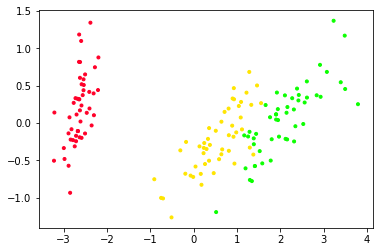

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [8]:
# experiment with plotting ellipses
# this will be useful later when we learn the 
# covariances for each cluster

centroids = np.zeros((dim, 3))
cov = np.zeros((3, dim, dim))
for k in range(3): 
    # get data from this feature
    iris_features_k = iris_features[iris_species == k, :]
    
    # get centroid
    centroids[:, k] = np.mean(iris_features_k, axis = 0)
    
    # get covariance
    cov[k, :, :] = np.cov(iris_features_k.T)


In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

In [10]:
centroids_pc, cov_pc = transform_params_to_pc_space(pca_fit, centroids, cov)

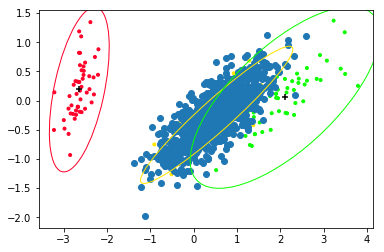

In [11]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig, \
              centroids_pc, cov_pc)

k = 1
samples = np.random.multivariate_normal(centroids[:, k], cov[k], size = 1000)
# samples_pc = pca_fit.transform(samples)
samples_pc = np.random.multivariate_normal(centroids_pc[:, k], cov_pc[k], size = 1000)
fig.scatter(samples_pc[:, 0], samples_pc[:, 1])

# Set prior params

In [12]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.5)

In [13]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]


# Set up model

In [14]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [15]:
set_truth = False

In [16]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [17]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

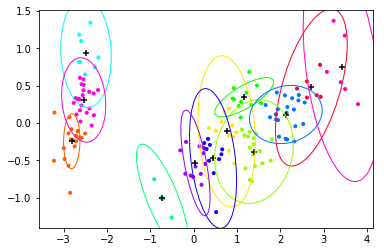

In [18]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [19]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [20]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [21]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 3923.3461764996596
Iter: 10	 RMSE: 7.439700285433405	 Objective: 2412.3572280763615
Iter: 20	 RMSE: 9.188684529979163	 Objective: 1330.5286468904571
Iter: 30	 RMSE: 13.700601890142583	 Objective: 67.9441864273771
Iter: 40	 RMSE: 9.562596059559585	 Objective: -204.17181314027098
Iter: 50	 RMSE: 9.424205795338937	 Objective: -296.04704239322047
Iter: 60	 RMSE: 9.17579544828184	 Objective: -333.04061504303223
Iter: 70	 RMSE: 9.124190268104288	 Objective: -340.55035786562263
Iter: 80	 RMSE: 9.060098330835014	 Objective: -344.51882019074804
Iter: 90	 RMSE: 9.05857807957658	 Objective: -346.17295880419834
Iter: 100	 RMSE: 8.992734339127532	 Objective: -347.0039147848681
         Current function value: -347.438987
         Iterations: 100
         Function evaluations: 107
         Gradient evaluations: 107
Iter: 110	 RMSE: 8.978089549740771	 Objective: -345.83056842356467
Iter: 120	 RMSE: 8.94493882689305	 Objective: -349.7087385348598
Iter: 130

In [22]:
newton_results = deepcopy(model)

In [23]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]


In [24]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [25]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

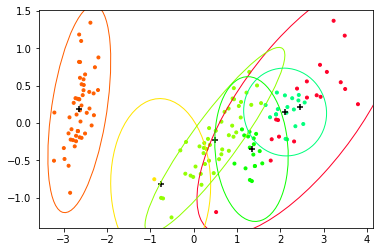

In [26]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors2, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

In [27]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

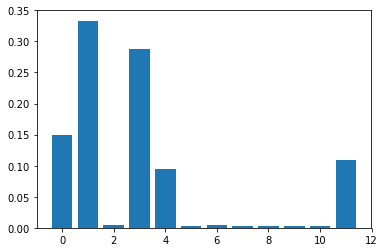

In [28]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

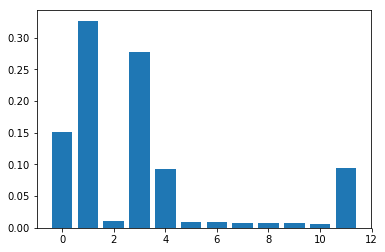

In [29]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  1.,   0.,   1.,   2.,   2.,   9.,   7.,  12.,  15., 101.]),
 array([0.20078168, 0.28070351, 0.36062534, 0.44054717, 0.52046901,
        0.60039084, 0.68031267, 0.7602345 , 0.84015634, 0.92007817,
        1.        ]),
 <a list of 10 Patch objects>)

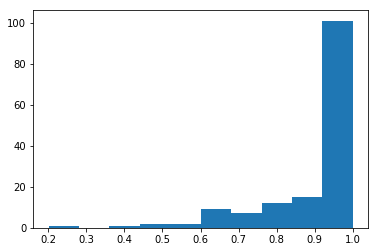

In [30]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Lets look at a few random restarts, see how results chage

In [35]:
n_restarts = 6
init_global_free_param_array = []
global_free_param_array = []

for i in tqdm(range(n_restarts)):
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500, disp=True)
    
    init_global_free_param_array.append(init_global_free_param)
    global_free_param_array.append(best_param)



  0%|          | 0/6 [00:00<?, ?it/s]

Iter: 0	 RMSE: 5.598913912817113	 Objective: 8507.889774110045
Iter: 10	 RMSE: 6.933107224589294	 Objective: 4368.45716507666
Iter: 20	 RMSE: 12.609054453982985	 Objective: 2557.292795656267
Iter: 30	 RMSE: 14.46344068179838	 Objective: 709.3007365338524
Iter: 40	 RMSE: 14.142128289139624	 Objective: 78.90088781060203
Iter: 50	 RMSE: 12.521010502188298	 Objective: -162.46854846209175
Iter: 60	 RMSE: 12.441841679984664	 Objective: -253.65262205482927
Iter: 70	 RMSE: 12.509732487426637	 Objective: -296.9994667143453
Iter: 80	 RMSE: 12.441666532156699	 Objective: -311.9171418140981
Iter: 90	 RMSE: 12.331501465514606	 Objective: -316.4826836713215
Iter: 100	 RMSE: 11.798367378949855	 Objective: -318.8675104092046
Iter: 110	 RMSE: 11.294407311071602	 Objective: -324.06014226320053
         Current function value: -324.060142
         Iterations: 100
         Function evaluations: 111
         Gradient evaluations: 111
Iter: 120	 RMSE: 11.013710652442754	 Objective: -334.6767468263023
Iter: 

 17%|█▋        | 1/6 [01:12<06:01, 72.37s/it]

         Current function value: -336.781413
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 6.553264875197584e-14, f_diff = 1.3642420526593924e-12
Iter: 0	 RMSE: 5.501912308288866	 Objective: 8820.425278378143
Iter: 10	 RMSE: 8.5877228792889	 Objective: 4333.987744385531
Iter: 20	 RMSE: 10.234876851966105	 Objective: 3135.906997884558
Iter: 30	 RMSE: 11.746732965854925	 Objective: 370.8482524211662
Iter: 40	 RMSE: 12.895045268624482	 Objective: -13.941837458348061
Iter: 50	 RMSE: 11.850851657971294	 Objective: -164.24912601553746
Iter: 60	 RMSE: 10.85871883969996	 Objective: -261.9681565565468
Iter: 70	 RMSE: 10.487071909017011	 Objective: -312.5923273265594
Iter: 80	 RMSE: 9.594068507714896	 Objective: -330.3785053877847
Iter: 90	 RMSE: 10.074048574980024	 Objective: -334.21620866889043
Iter: 100	 RMSE: 9.832197252542029	 Objective: -336.6307179889746
         Current function value: -337.525151

 33%|███▎      | 2/6 [04:19<08:39, 129.96s/it]

         Current function value: -359.317882
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.4428900622682796e-14, f_diff = 1.8758328224066645e-12
Iter: 0	 RMSE: 6.292717731907797	 Objective: 8702.082325725556
Iter: 10	 RMSE: 8.03565337000975	 Objective: 4477.126355606373
Iter: 20	 RMSE: 10.168868752754653	 Objective: 3094.5285431334846
Iter: 30	 RMSE: 13.257998728789389	 Objective: 682.5343984125471
Iter: 40	 RMSE: 11.068549140784464	 Objective: 88.60216177928501
Iter: 50	 RMSE: 8.890632516956158	 Objective: -94.63531500792095
Iter: 60	 RMSE: 9.308801107788643	 Objective: -170.75274340981554
Iter: 70	 RMSE: 9.109908177493647	 Objective: -253.20597175854044
Iter: 80	 RMSE: 8.07009274580563	 Objective: -310.7992564498043
Iter: 90	 RMSE: 7.949437805890016	 Objective: -331.16649738647214
Iter: 100	 RMSE: 7.695252489304886	 Objective: -341.8902905489545
         Current function value: -343.404432
 

 50%|█████     | 3/6 [08:02<08:02, 160.73s/it]

         Current function value: -351.480733
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 6.23666157779923e-14, f_diff = 7.389644451905042e-13
Iter: 0	 RMSE: 5.969175400059551	 Objective: 3704.776583054847
Iter: 10	 RMSE: 8.157834951978785	 Objective: 2420.714826032214
Iter: 20	 RMSE: 12.834757337971427	 Objective: 1300.731265616699
Iter: 30	 RMSE: 13.416664465817437	 Objective: 99.64539382484332
Iter: 40	 RMSE: 13.065499656102405	 Objective: -222.83988710544054
Iter: 50	 RMSE: 11.966213614848305	 Objective: -309.07763648338937
Iter: 60	 RMSE: 11.172706027498815	 Objective: -323.0788946111825
Iter: 70	 RMSE: 10.424911623652177	 Objective: -335.64434460568833
Iter: 80	 RMSE: 10.324265128636117	 Objective: -340.44562104778925
Iter: 90	 RMSE: 9.815094821629025	 Objective: -343.3546099175295
Iter: 100	 RMSE: 9.599779427253148	 Objective: -345.05292187049497
Iter: 110	 RMSE: 9.29979224006931	 Object

 67%|██████▋   | 4/6 [09:43<04:51, 145.81s/it]

Iter: 150	 RMSE: 7.185812699513511	 Objective: -360.0351259797823
         Current function value: -360.035126
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.728674912913734e-14, f_diff = 0.0
Iter: 0	 RMSE: 6.677848926271651	 Objective: 3869.7447053294873
Iter: 10	 RMSE: 7.507893773808581	 Objective: 2507.6363380398357
Iter: 20	 RMSE: 9.890240222593764	 Objective: 1561.7637326877766
Iter: 30	 RMSE: 13.635885840073337	 Objective: 261.75913537870855
Iter: 40	 RMSE: 12.826421979783804	 Objective: -191.40535053598643
Iter: 50	 RMSE: 12.223088121716952	 Objective: -299.6043611537067
Iter: 60	 RMSE: 12.092305885182189	 Objective: -314.6121634491598
Iter: 70	 RMSE: 11.341591523647496	 Objective: -322.16162275600664
Iter: 80	 RMSE: 10.275001920707489	 Objective: -335.3230305760861
Iter: 90	 RMSE: 10.01390605822475	 Objective: -340.36382913632934
Iter: 100	 RMSE: 9.531471131419273	 Objective: -343.12654

 83%|████████▎ | 5/6 [15:34<03:06, 187.00s/it]

         Current function value: -358.294506
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.930135939594128e-14, f_diff = 5.684341886080801e-13
Iter: 0	 RMSE: 5.509730988580523	 Objective: 8530.031790059878
Iter: 10	 RMSE: 6.825835080078222	 Objective: 4388.802501781658
Iter: 20	 RMSE: 13.631628581534702	 Objective: 2764.9010917317096
Iter: 30	 RMSE: 16.759138201374558	 Objective: 834.1829855601051
Iter: 40	 RMSE: 13.076367296313645	 Objective: 96.41443988797877
Iter: 50	 RMSE: 12.653063885840552	 Objective: -136.83326619208037
Iter: 60	 RMSE: 12.43613973010623	 Objective: -256.3279905694529
Iter: 70	 RMSE: 12.340958386889858	 Objective: -303.43376291641596
Iter: 80	 RMSE: 11.689774444479534	 Objective: -315.7010470276126
Iter: 90	 RMSE: 10.514792527770268	 Objective: -324.53427459477143
Iter: 100	 RMSE: 10.191102889023506	 Objective: -336.3902756193329
         Current function value: -339.1

100%|██████████| 6/6 [16:57<00:00, 169.51s/it]

         Current function value: -359.756402
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.276374226859809e-14, f_diff = 1.5347723092418164e-12


In [36]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]


In [37]:
# get cluster assignments
cluster_assignments_array = []
bnp_centroids_pc_array = []
bnp_cluster_covs_pc_array = []

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    bnp_centroids_pc_, bnp_cluster_covs_pc_ = \
        transform_params_to_pc_space(pca_fit, \
                                     model.vb_params['global']['centroids'].get(),\
                                     np.linalg.inv(model.vb_params['global']['gamma'].get()))
        
    bnp_centroids_pc_array.append(bnp_centroids_pc_)
    bnp_cluster_covs_pc_array.append(bnp_cluster_covs_pc_)
    
    cluster_assignments_array.append(np.argmax(model.vb_params['e_z'].get(), axis = 1))
    
    print('final objective val, restart {}: '.format(i), model.set_z_get_kl())

final objective val, restart 0:  -336.7814132301266
final objective val, restart 1:  -359.3178821315438
final objective val, restart 2:  -351.4807333971628
final objective val, restart 3:  -360.03512597978033
final objective val, restart 4:  -358.29450559924516
final objective val, restart 5:  -359.75640176986343


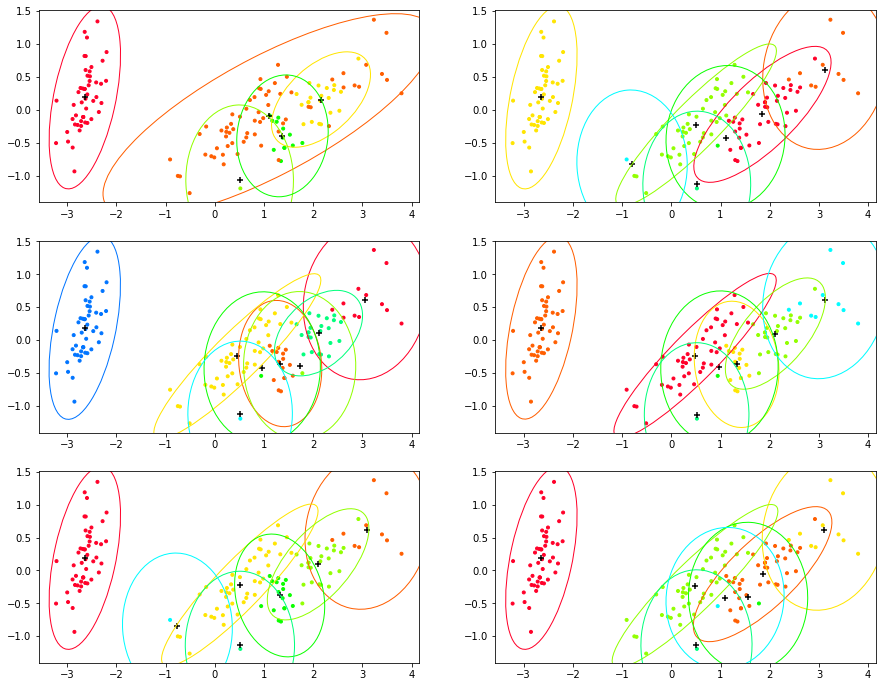

In [38]:
f, axarr = plt.subplots(3, 2, figsize = (15, 12))

for i in range(n_restarts): 
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2
    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments_array[i], \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = bnp_centroids_pc_array[i][:, np.unique(cluster_assignments_array[i])], \
                 cov = bnp_cluster_covs_pc_array[i][np.unique(cluster_assignments_array[i])])

In [41]:
# %%R
# # an R multiplot function
# multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
#   library(grid)

#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)

#   numPlots = length(plots)

#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                     ncol = cols, nrow = ceiling(numPlots/cols))
#   }

#  if (numPlots==1) {
#     print(plots[[1]])

#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
#   }
# }


In [42]:
# %%R -i cluster_assignments_array -i n_restarts -w 5 -h 8 --units in -r 200
# # pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# # pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# plot_list <- list()
# for(i in 1:n_restarts){
#     # add our bnp clusterings to the dataframe
#     # print(cluster_assignments_array[, i])
#     df_pca$bnp_clusters <- as.factor(cluster_assignments_array[, i])
    
#     plot <- ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#      theme(legend.position="none") 
    
#     plot_list[[i]] <- plot
# }

# # plot_list[[1]]

# multiplot(plotlist = plot_list, cols = 2)

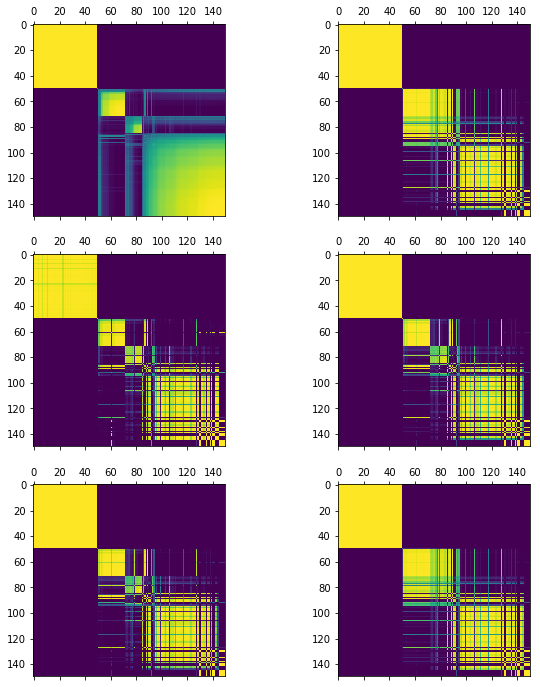

In [39]:
f, axarr = plt.subplots(3, 2, figsize=(10, 12))

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
    if i == 0: 
        dis = (co_cluster_mat + 1) ** (-1)
        dis[np.diag_indices_from(dis)] = 0
        dis = spatial.distance.squareform(dis, checks=False)
        y = sch.linkage(dis, method='average')
        indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx][:, indx]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)
    

# Parametric sensitivity

In [31]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [32]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)


In [33]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.2342357757792829 2758.765330797667


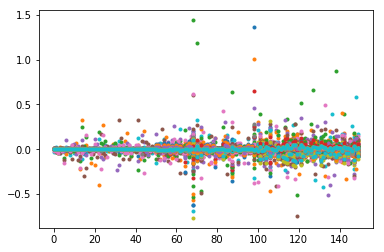

In [34]:
# sensitivity to data
plt.plot(linear_sens.data_sens_mat.T, '.');


In [35]:
# We perturb the diagonal entries on the 
# wishart prior scale

epsilon = 0.01

model_perturbed = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

og_wishart_inv_scale = newton_results.prior_params['prior_gamma_inv_scale'].get()

model_perturbed.prior_params['prior_gamma_inv_scale'].set(
    og_wishart_inv_scale + np.eye(dim) * epsilon)

print(model_perturbed.prior_params)

prior_params:
	alpha: [4.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.51 0.   0.   0.  ]
 [0.   0.51 0.   0.  ]
 [0.   0.   0.51 0.  ]
 [0.   0.   0.   0.51]]


In [36]:
# Re-optimize
pert_opt_free_param = \
    model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 7.952765768758866	 Objective: -348.5632293747191
Iter: 10	 RMSE: 7.955056652553499	 Objective: -348.5758755710415
Iter: 20	 RMSE: 7.96086141587226	 Objective: -348.58089767536603
Iter: 30	 RMSE: 7.96089250489005	 Objective: -348.58444887778376
Iter: 40	 RMSE: 7.963327770649297	 Objective: -348.5848681591983
Iter: 50	 RMSE: 7.965445367230674	 Objective: -348.5854357270964
Iter: 60	 RMSE: 7.966599160066143	 Objective: -348.5855451530351
Iter: 70	 RMSE: 7.966919866329093	 Objective: -348.58555266308866
Iter: 80	 RMSE: 7.966893282430455	 Objective: -348.5855527271944
Optimization terminated successfully.
         Current function value: -348.585553
         Iterations: 66
         Function evaluations: 82
         Gradient evaluations: 82
         Current function value: -348.585553
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 0.00018602965733970696, f_diff = 1.4244960766518489e-10


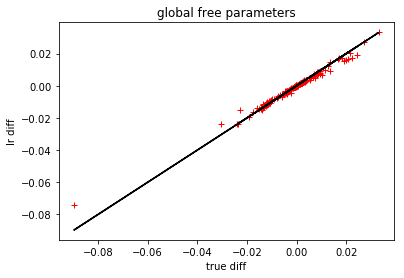

In [37]:
free_perturb_vec = model_perturbed.prior_params.get_free() - model.prior_params.get_free()
lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

diff_vec = pert_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')
plt.title('global free parameters')


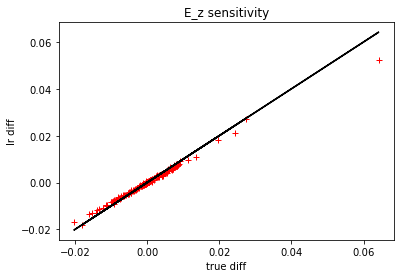

In [38]:
## check e_z sensitivity

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_orig = np.mean(e_z_orig, axis = 0)

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_pert = np.mean(e_z_pert, axis = 0)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_lr = np.mean(e_z_lr, axis = 0)

diff_vec = (e_z_pert - e_z_orig).flatten()
lr_diff_vec = (e_z_lr - e_z_orig).flatten()

plt.title('E_z sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


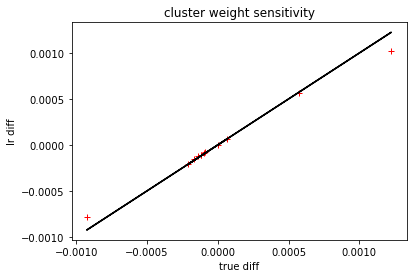

In [39]:
# check sensitivity of cluster weights

diff_vec = (np.sort(cluster_weights_pert) - np.sort(cluster_weights_orig)).flatten()
lr_diff_vec = (np.sort(cluster_weights_lr) - np.sort(cluster_weights_orig)).flatten()

plt.title('cluster weight sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


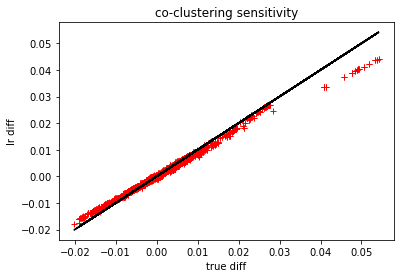

In [40]:
# check co-clustering sensitivity
coclustering_orig = np.matmul(e_z_orig, e_z_orig.T)
coclustering_pert = np.matmul(e_z_pert, e_z_pert.T)
coclustering_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (coclustering_pert - coclustering_orig).flatten()
lr_diff_vec = (coclustering_lr - coclustering_orig).flatten()


plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


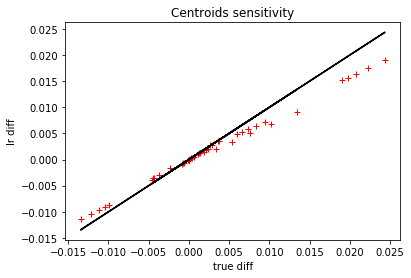

In [41]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_beta_lr = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec = (e_beta_pert - e_beta_orig).flatten()
lr_diff_vec = (e_beta_lr - e_beta_orig).flatten()

plt.title('Centroids sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [42]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return common_modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [43]:
get_e_number_clusters_from_free_par(model, newton_results.global_vb_params.get_free())

8.114753063294431

In [44]:
get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)

8.079147177529496

In [45]:
get_e_number_clusters_from_free_par(model, pert_opt_free_param)

8.079589289449927

# check how well the linear approximation holds over a range of epsilons

In [46]:
epsilons = [-0.4, -0.3, -0.20, -0.16, -0.12, -0.08, -0.04, 0.04, 0.08, 0.12]
pert_opt_free_param_list = []
pert_prior_free_params_list = []

# re-optimize for each epsilon
for i in range(len(epsilons)): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    og_wishart_inv_scale = newton_results.prior_params['prior_gamma_inv_scale'].get()
    model_perturbed.prior_params['prior_gamma_inv_scale'].set(
                og_wishart_inv_scale + np.eye(dim) * epsilons[i])
    
    print(model_perturbed.prior_params)
    
    pert_prior_free_params_list.append(model_perturbed.prior_params.get_free())
    
    pert_opt_free_param_list.append(
        model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = False)[0])


optimizing when epsilon = -0.4
prior_params:
	alpha: [4.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]
optimizing when epsilon = -0.3
prior_params:
	alpha: [4.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.2 0.  0.  0. ]
 [0.  0.2 0.  0. ]
 [0.  0.  0.2 0. ]
 [0.  0.  0.  0.2]]
optimizing when epsilon = -0.2
prior_params:
	alpha: [4.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.3 0.  0.  0. ]
 [0.  0.3 0.  0. ]
 [0.  0.  0.3 0. ]
 [0.  0.  0.  0.3]]
optimizing when epsilon = -0.16
prior_params:
	alpha: [4.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.34 0.   0.   0.  ]
 [0.   0.34 0.   0.  ]
 [0.   0.   0.34 0.  ]
 [0.   0.   0.   0.34]]
optimizing when epsilon = -0.12
prior_p

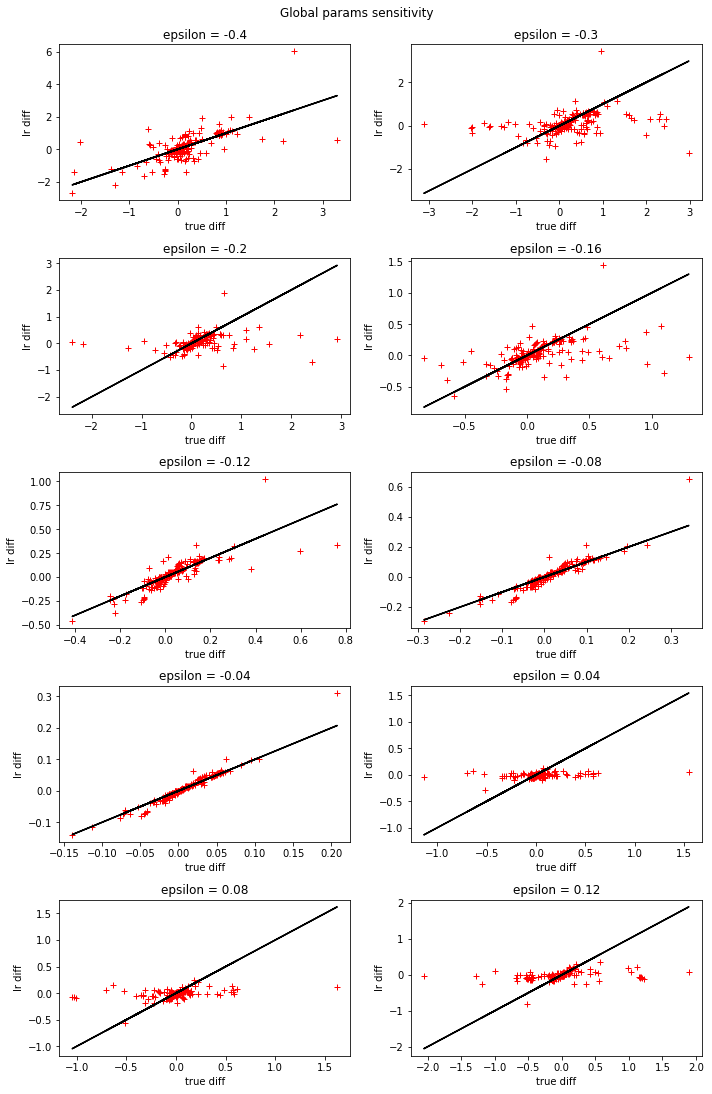

In [47]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)


f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
    
    # diff in prior free params
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    
    # get linear response global free params
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    lr_diff_vec = (lr_free_param_diff_vec).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


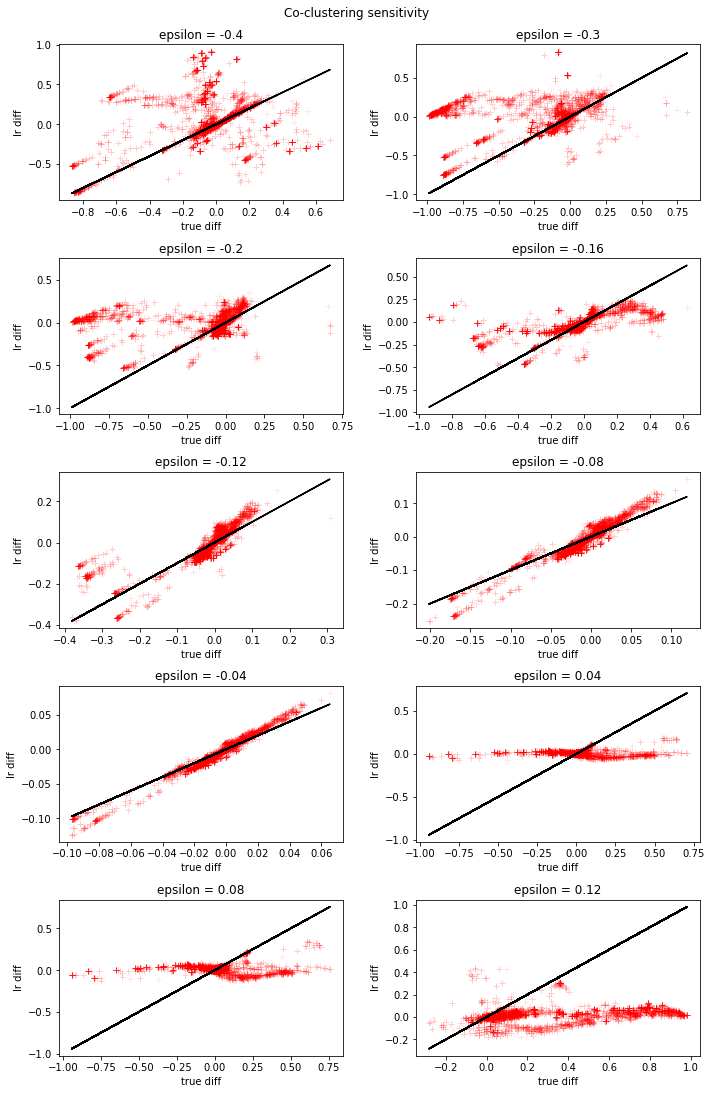

In [48]:
# check e_z's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Co-clustering sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (co_cluster_pert - co_cluster_og).flatten()
    lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+', alpha = 0.1)
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


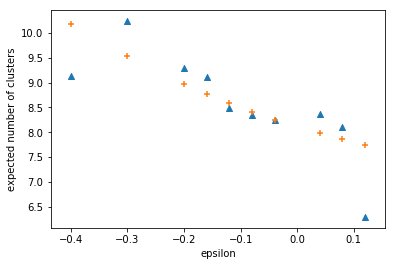

In [49]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i])
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

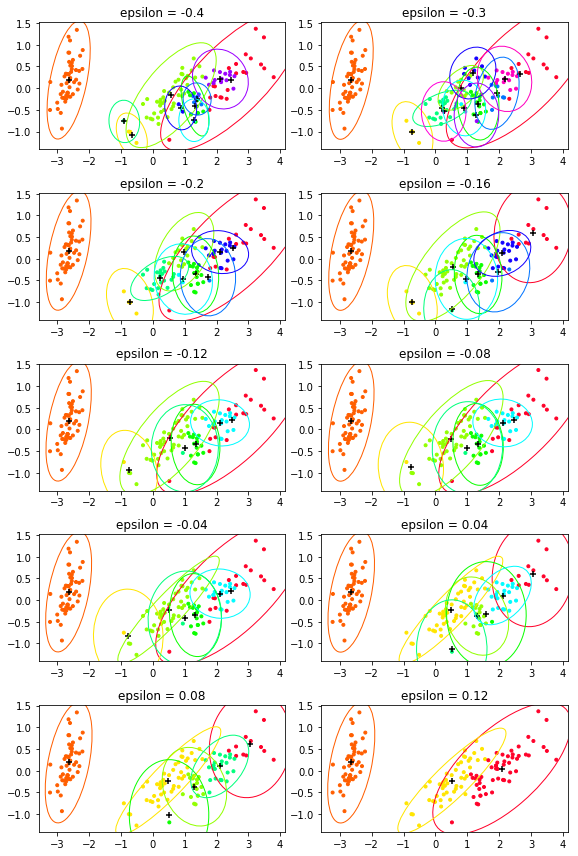

In [50]:
# check e_z's 
f, axarr = plt.subplots(int(len(epsilons)/2), 2, figsize = (8, 12))

for i in range(len(epsilons)): 
    
    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    cluster_assignments = np.argmax(e_z_pert, axis = 1)
    
    centroids = linear_sens.moment_model.moment_params['centroids'].get()
    covs = np.linalg.inv(linear_sens.moment_model.model.vb_params['global']['gamma'].get())

    pc_centroids, pc_covs = transform_params_to_pc_space(pca_fit, centroids, covs)
    
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2

    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments, \
                  colors2, axarr[axarr_indx1, axarr_indx2], 
                 centroids = pc_centroids[:, np.unique(cluster_assignments)], \
                 cov = pc_covs[np.unique(cluster_assignments)])
    axarr[axarr_indx1, axarr_indx2].set_title('epsilon = {}'.format(epsilons[i]))
    
f.tight_layout()


### what if we perturb and start from a different initialization 

In [112]:
model_perturbed2 = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = 0.5

model_perturbed2.prior_params.set_vector(
    model.prior_params.get_vector() + perturb_vec)

print(model_perturbed2.prior_params.get_vector())
print(model_perturbed2.prior_indices)


print('k-means initialization ...')
t0 = time.time()
init_global_free_param = model_perturbed2.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
t_kmeans = time.time() - t0

pert_opt_free_param2 = \
    model_perturbed2.optimize_full(init_global_free_param, init_max_iter=100, final_max_iter=500)[0]


[1.5 0.  0.1 8.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1. ]
prior_params:
	alpha: [0]
	prior_centroid_mean: [1]
	prior_centroid_info: [2]
	prior_gamma_df: [3]
	prior_gamma_inv_scale:
[[ 4.  5.  7. 10.]
 [ 5.  6.  8. 11.]
 [ 7.  8.  9. 12.]
 [10. 11. 12. 13.]]
k-means initialization ...
Iter: 0	 RMSE: 5.924091381221903	 Objective: 7519.573594239765
Iter: 10	 RMSE: 8.381054885028085	 Objective: 4421.849717035486
Iter: 20	 RMSE: 10.345345114299814	 Objective: 1035.877627059759
Iter: 30	 RMSE: 17.507463419619288	 Objective: 143.35461257573837
Iter: 40	 RMSE: 11.72247857867356	 Objective: -59.52772754629132
Iter: 50	 RMSE: 9.56699093307698	 Objective: -145.57170688367347
Iter: 60	 RMSE: 8.666841569053313	 Objective: -184.68207144772498
Iter: 70	 RMSE: 8.16607183338157	 Objective: -216.1934997325391
Iter: 80	 RMSE: 8.102264895578793	 Objective: -227.28812607914352
Iter: 90	 RMSE: 7.867785647173199	 Objective: -235.91134693216264
Iter: 100	 RMSE: 7.914399207836115	 Objective: -239.2834953152996

In [113]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

# results when starting from original optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)

# results when starting from random new optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param2)
e_z_pert2 = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert2 = np.matmul(e_z_pert2, e_z_pert2.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_cluster_pert2 - co_cluster_og).flatten()
lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()


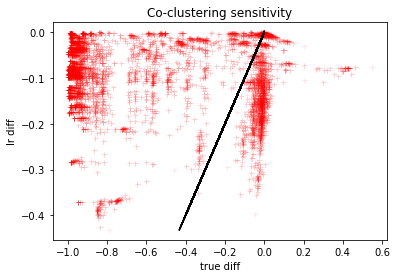

In [114]:
#indx = np.abs(diff_vec) < 0.008
plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


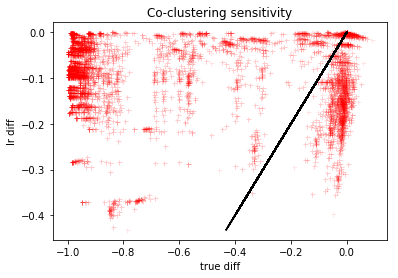

In [115]:
# Lets look at co-clustering again, but subsetting to 
# those with confident cluster belonings

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()

sure_indx = np.argwhere(np.max(e_z_orig, axis = 1) > 0.9).flatten()

co_cluster_sure_og = np.matmul(e_z_orig[sure_indx, :], e_z_orig[sure_indx, :].T)
co_cluster_sure_pert2 = np.matmul(e_z_pert2[sure_indx, :], e_z_pert2[sure_indx, :].T)
co_cluster_sure_lr = np.matmul(e_z_lr[sure_indx, :], e_z_lr[sure_indx, :].T)

diff_vec = (co_cluster_sure_pert2 - co_cluster_sure_og).flatten()
lr_diff_vec = (co_cluster_sure_lr - co_cluster_sure_og).flatten()

plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


# Functional Sensitivty

In [65]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

get_g_eta = autograd.jacobian(get_stick_length_from_free_param, argnum = 1)
g_eta = get_g_eta(model, best_param)


In [66]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx - 1, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


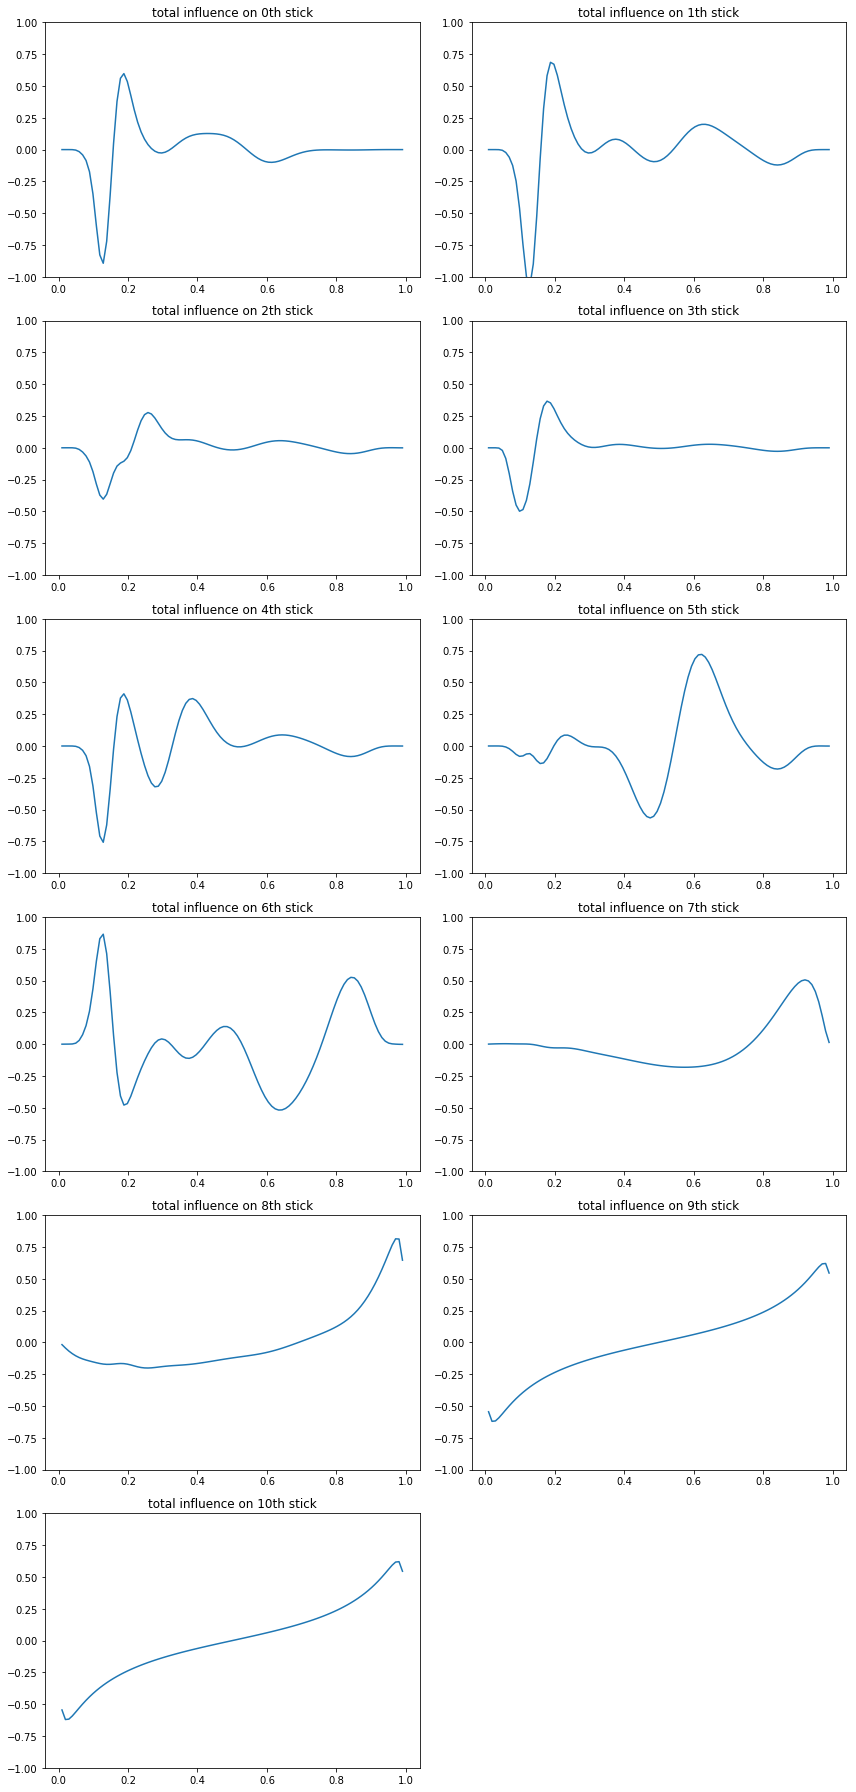

In [67]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-1.0, 1.0])
    axarr[indx1, indx2].set_title('total influence on {}th stick'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [68]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [69]:
# we examine the influence on the posterior stick lengths
def get_centroid_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return model.global_vb_params['centroids'].get().T.flatten()

get_g_eta_for_centroids= autograd.jacobian(get_centroid_from_free_param, argnum = 1)
g_eta_for_centroids = get_g_eta_for_centroids(model, best_param)


In [70]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_centroids = np.zeros((np.shape(g_eta_for_centroids)[0], len(theta)))
for k in range(k_approx - 1): 
    total_influence_centroids += np.dot(g_eta_for_centroids, linear_sens.influence_function(theta, k))


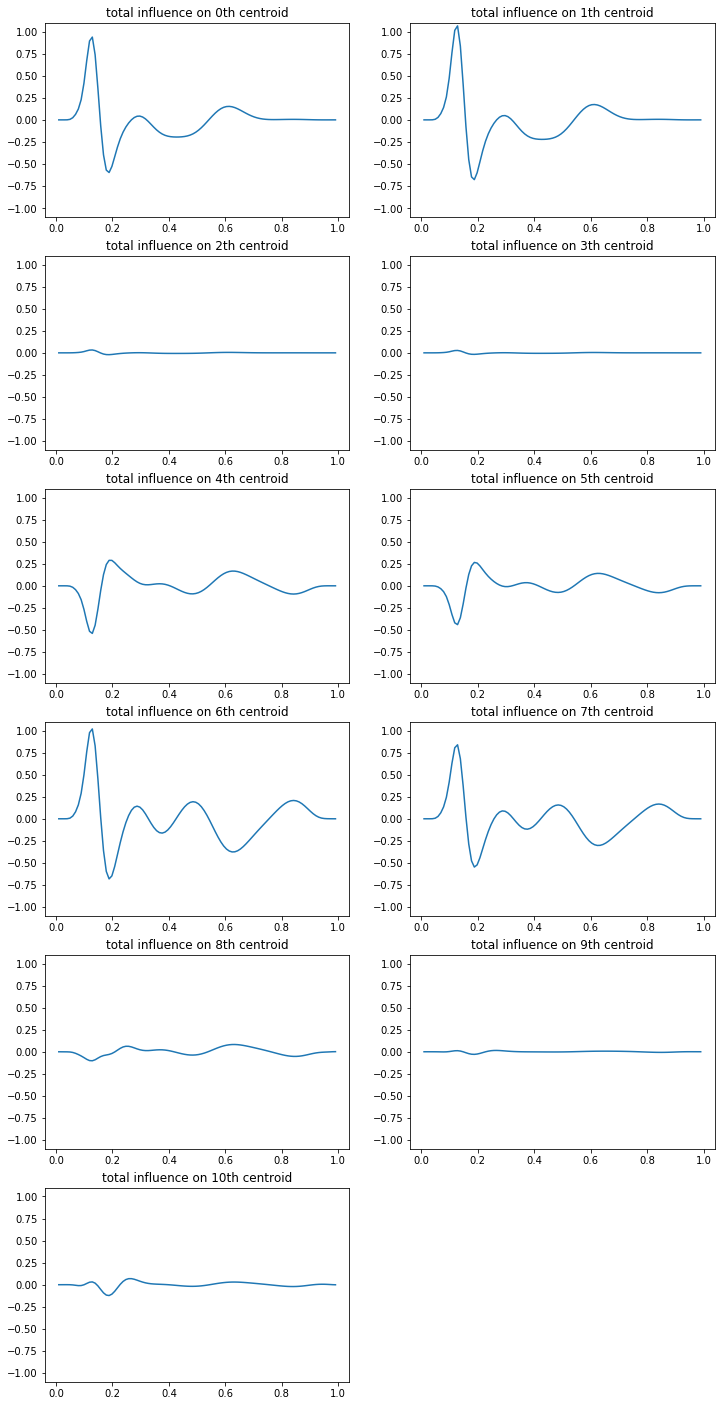

In [71]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_centroids[k, :])
    axarr[indx1, indx2].set_ylim([-1.1, 1.1])
    axarr[indx1, indx2].set_title('total influence on {}th centroid'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])



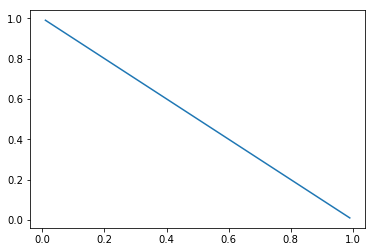

In [72]:
# lets choose a perturbation 
epsilon = 1000.0

u = lambda x : 1.0 - x

plt.plot(theta, u(theta))

In [73]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(u)

In [74]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [75]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = u)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 4.962531977587545	 Objective: -147.9431083698631
Iter: 10	 RMSE: 4.9661318414035565	 Objective: -147.97083862442423
Iter: 20	 RMSE: 4.963603040273021	 Objective: -147.99522513808878
Iter: 30	 RMSE: 4.962654546850977	 Objective: -148.00463164783486
Iter: 40	 RMSE: 4.962475732908162	 Objective: -148.00827900910286
Iter: 50	 RMSE: 4.962224268839583	 Objective: -148.00950956212336
Iter: 60	 RMSE: 4.9620868604423345	 Objective: -148.0099418078949
Iter: 70	 RMSE: 4.962103954001901	 Objective: -148.00994587631635
Optimization terminated successfully.
         Current function value: -148.009946
         Iterations: 55
         Function evaluations: 72
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: -148.009946
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 8.460823103424496e-06, f_diff = 3.524291969370097e-12


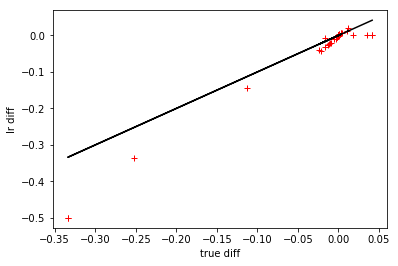

In [76]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


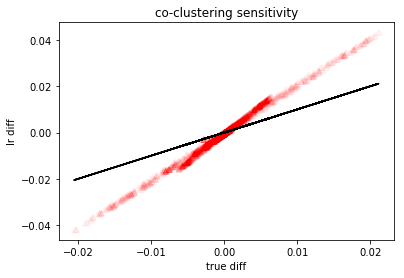

In [77]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


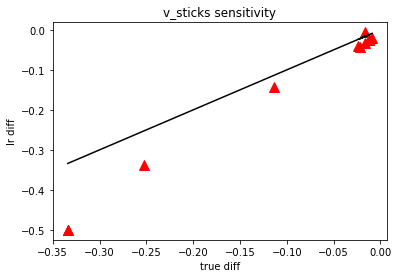

In [78]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


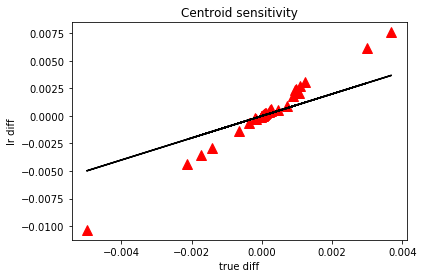

In [79]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')
